### NẠP THƯ VIỆN

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

### NẠP FILE DỮ LIỆU ĐÃ XỬ LÝ BẰNG EXCEL

### Đọc file excel

In [33]:
%pip install openpyxl
df = pd.read_excel('DataCO2.xlsx', engine='openpyxl')


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### TIỀN XỬ LÝ DỮ LIỆU

### Loại bỏ các dòng trùng lặp

In [34]:
df = df.drop_duplicates()

### Chuẩn hóa và chuyển các cột định lượng sang dạng numeric

In [35]:
numeric_cols = [
 'population',	'gdp',	'co2',	'co2_per_capita',	'co2_per_gdp',	'co2_growth_abs',	'co2_growth_prct',	'cement_co2',	'coal_co2',	'flaring_co2',	'gas_co2',	'land_use_change_co2',	'oil_co2',	'primary_energy_consumption',	'temperature_change_from_co2'
 ]

for c in numeric_cols + ['year']:
    if c in df.columns:
        df[c] = (
            df[c].astype(str)                          # Ép mọi giá trị thành chuỗi
                 .str.replace(",", "", regex=False)    # Loại bỏ dấu phẩy ("1,000" → "1000")
                 .str.replace(" ", "", regex=False)    # Loại bỏ khoảng trắng (" 1000 " → "1000")
                 .replace({"": np.nan, "nan": np.nan, "NA": np.nan, "N/A": np.nan})  # Chuẩn hóa giá trị rỗng về NaN
        )
        df[c] = pd.to_numeric(df[c], errors="coerce")  # Chuyển thành số


### Chuẩn hóa và chuyển cột Name sang dạng sang dạng string

In [36]:
df['Name'] = df['Name'].astype(str).str.strip()

In [37]:
df.head()

,Description,Name,year,iso_code,population,gdp,co2,co2_per_capita,co2_per_gdp,co2_growth_abs,co2_growth_prct,cement_co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,primary_energy_consumption,temperature_change_from_co2
0,Country,Afghanistan,2000,AFG,20130334.0,1.128379e+10,1.047,0.052,0.093,-0.045,-4.078,0.010,0.004,0.022,0.224,0.057,0.788,5.914,0.000
1,Country,Albania,2000,ALB,3166147.0,1.473684e+10,3.025,0.053,0.097,0.039,1.297,0.094,0.070,0.000,0.022,-0.087,2.840,28.732,0.000
2,Country,Algeria,2000,DZA,30903895.0,2.085540e+11,85.399,0.063,0.071,-6.051,-6.616,3.789,1.960,14.287,38.534,5.087,26.828,299.946,0.001
3,Country,Andorra,2000,AND,65703.0,NaN,0.524,0.069,0.074,0.011,2.143,0.000,0.000,0.000,NaN,0.029,0.524,NaN,0.000
4,Country,Angola,2000,AGO,16194872.0,2.351218e+10,15.995,0.053,0.055,-1.266,-7.335,0.081,NaN,11.162,1.085,23.296,3.668,32.448,0.002


### PHÂN CỤM CÁC QUỐC GIA THEO MỨC PHÁT THẢI CO2 TRUNG BÌNH GIAI ĐOẠN 2000-2023

### Chuẩn bị dữ liệu

In [38]:
# Nạp thư viện
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Lọc riêng quốc gia và chỉ lấy năm 2023
df_country = df[df["Description"] == "Country"].copy()

# Gộp trung bình 23 năm cho từng quốc gia
df_country_mean = (
    df_country
    .groupby("Name")[[
        'population', 'gdp', 'co2', 'co2_per_capita', 'co2_per_gdp',
        'co2_growth_abs', 'co2_growth_prct', 'cement_co2', 'coal_co2',
        'flaring_co2', 'gas_co2', 'land_use_change_co2', 'oil_co2',
        'primary_energy_consumption', 'temperature_change_from_co2'
    ]]
    .mean()
    .reset_index()
)

# Lấy tên quốc gia làm nhãn
countries = df_country["Name"]
data_cluster = df_country[numeric_cols].copy()

### Xử lý dữ liệu bị thiếu bằng Median

In [39]:
for col in data_cluster.columns:
    if data_cluster[col].isna().sum() > 0:
        data_cluster[col] = data_cluster[col].fillna(data_cluster[col].median())

### Chuẩn hóa dữ liệu StandardScaler

In [40]:
scaler = StandardScaler()
X = scaler.fit_transform(data_cluster)
preprocessed = pd.DataFrame(data=X, columns=numeric_cols)

### Giảm chiều dữ liệu bằng PCA

In [41]:
pca = PCA(n_components=None)
data_clusterx_pca = pca.fit(preprocessed)
data_clusterx_pca.explained_variance_ratio_
n_components = sum(data_clusterx_pca.explained_variance_ratio_ > 0.1)
pca = PCA(n_components=n_components)
CO2_PCA = pca.fit_transform(preprocessed)
print(n_components)

2


### Chọn tham số K bằng Elbow Method

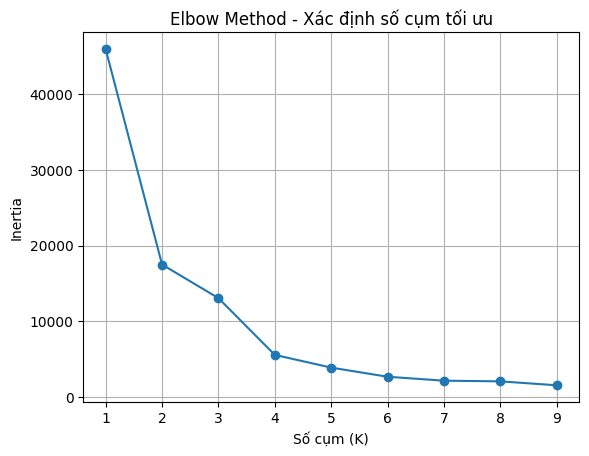

In [42]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(CO2_PCA)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title("Elbow Method - Xác định số cụm tối ưu")
plt.xlabel("Số cụm (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(CO2_PCA)

,n_clusters,3
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


### Đánh giá mô hình bằng SILHOUETTE_SCORE

In [44]:
from sklearn.metrics import r2_score, silhouette_score

km_inertias, km_scores = [], []
for k in range(3, 10):
    km = KMeans(n_clusters=k).fit(X)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X, km.labels_))
    print(f"Processing K-Means with k = {k}, Intertia = {km.inertia_}, Silhoutte Score = {silhouette_score(X, km.labels_)}")
km_inertias

Processing K-Means with k = 3, Intertia = 34866.75598255408, Silhoutte Score = 0.9068651672076261
Processing K-Means with k = 4, Intertia = 29074.226715985988, Silhoutte Score = 0.7932031414802158
Processing K-Means with k = 5, Intertia = 26568.827187314826, Silhoutte Score = 0.778630770325459
Processing K-Means with k = 6, Intertia = 22801.007122496772, Silhoutte Score = 0.5211514320787916
Processing K-Means with k = 7, Intertia = 18306.94526660382, Silhoutte Score = 0.5481042015765726
Processing K-Means with k = 8, Intertia = 15734.458555879017, Silhoutte Score = 0.5561521369230769
Processing K-Means with k = 9, Intertia = 14594.971557267172, Silhoutte Score = 0.31871157421480856


[34866.75598255408,
 29074.226715985988,
 26568.827187314826,
 22801.007122496772,
 18306.94526660382,
 15734.458555879017,
 14594.971557267172]

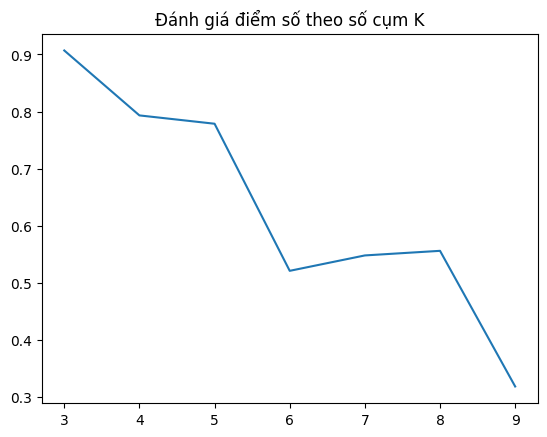

In [45]:
sns.lineplot (x=range(3,10), y=km_scores)
plt.title('Đánh giá điểm số theo số cụm K')
plt.show()

In [46]:
# Hiển thị ma trận thành phần (loadings)
pca_components = pd.DataFrame(
    pca.components_,
    columns=numeric_cols,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Xem biến nào ảnh hưởng mạnh nhất tới PC1 và PC2
print("=== Thành phần PCA ===")
display(pca_components.T)  # Hiển thị toàn bộ

# Hoặc chỉ lấy top biến có ảnh hưởng lớn nhất
print("\nTop biến ảnh hưởng đến PC1:")
print(pca_components.loc["PC1"].abs().sort_values(ascending=False).head(5))

print("\nTop biến ảnh hưởng đến PC2:")
print(pca_components.loc["PC2"].abs().sort_values(ascending=False).head(5))


=== Thành phần PCA ===


,PC1,PC2
population,0.280249,-0.274358
gdp,0.344343,0.047939
co2,0.356708,-0.091329
co2_per_capita,0.001989,0.043898
co2_per_gdp,0.003930,0.029923
co2_growth_abs,0.171056,-0.427037
co2_growth_prct,-0.002331,-0.017625
cement_co2,0.285972,-0.379906
coal_co2,0.318024,-0.299388
flaring_co2,0.201006,0.447373



Top biến ảnh hưởng đến PC1:
primary_energy_consumption     0.359765
co2                            0.356708
gdp                            0.344343
oil_co2                        0.330350
temperature_change_from_co2    0.320022
Name: PC1, dtype: float64

Top biến ảnh hưởng đến PC2:
flaring_co2       0.447373
co2_growth_abs    0.427037
gas_co2           0.392281
cement_co2        0.379906
coal_co2          0.299388
Name: PC2, dtype: float64


Xem giá trị trung bình của mỗi cụm

In [47]:
# Đảm bảo cột CO2 là số
df_country["co2"] = pd.to_numeric(df_country["co2"], errors="coerce")

# Gán nhãn cluster cho dữ liệu gốc
df_country["cluster"] = kmeans.labels_

# Tính trung bình CO2 theo cụm
cluster_summary = (
    df_country.groupby("cluster")["co2"]
    .mean()
    .sort_values()
)
print(cluster_summary)


cluster
0      94.538423
1    5562.299542
2    8776.318136
Name: co2, dtype: float64


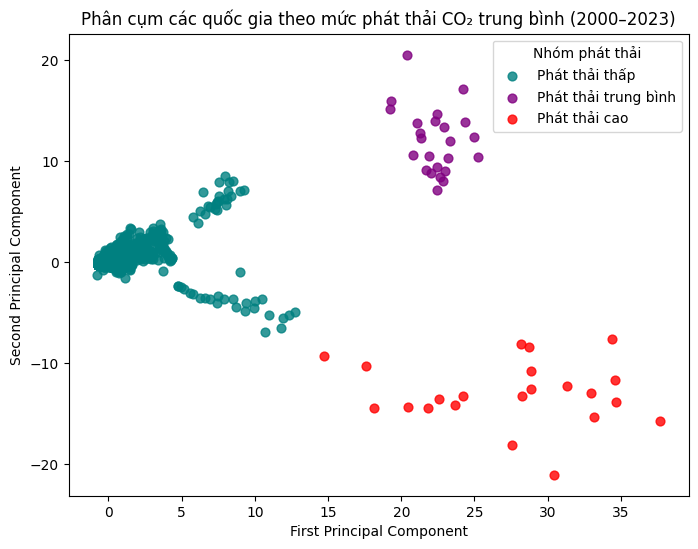

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Tạo mapping cụm → mức phát thải
cluster_labels = {
    0: "Phát thải thấp",
    1: "Phát thải trung bình",
    2: "Phát thải cao"
}

# Tạo mapping màu tương ứng
colors = {
    0: "teal",     # thấp
    1: "purple",       # trung bình
    2: "red"        # cao
}

# Vẽ scatter với màu theo mức phát thải
plt.figure(figsize=(8,6))
for cluster_id, label in cluster_labels.items():
    mask = kmeans.labels_ == cluster_id
    plt.scatter(
        CO2_PCA[mask, 0],
        CO2_PCA[mask, 1],
        c=colors[cluster_id],
        label=label,
        s=40,
        alpha=0.8
    )

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Phân cụm các quốc gia theo mức phát thải CO₂ trung bình (2000–2023)")
plt.legend(title="Nhóm phát thải")
plt.show()


### Gán nhãn cụm


In [49]:
df_country['cluster_label'] = kmeans.labels_
display(df_country.head())

,Description,Name,year,iso_code,population,gdp,co2,co2_per_capita,co2_per_gdp,co2_growth_abs,...,cement_co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,primary_energy_consumption,temperature_change_from_co2,cluster,cluster_label
0,Country,Afghanistan,2000,AFG,20130334.0,1.128379e+10,1.047,0.052,0.093,-0.045,...,0.010,0.004,0.022,0.224,0.057,0.788,5.914,0.000,0,0
1,Country,Albania,2000,ALB,3166147.0,1.473684e+10,3.025,0.053,0.097,0.039,...,0.094,0.070,0.000,0.022,-0.087,2.840,28.732,0.000,0,0
2,Country,Algeria,2000,DZA,30903895.0,2.085540e+11,85.399,0.063,0.071,-6.051,...,3.789,1.960,14.287,38.534,5.087,26.828,299.946,0.001,0,0
3,Country,Andorra,2000,AND,65703.0,NaN,0.524,0.069,0.074,0.011,...,0.000,0.000,0.000,NaN,0.029,0.524,NaN,0.000,0,0
4,Country,Angola,2000,AGO,16194872.0,2.351218e+10,15.995,0.053,0.055,-1.266,...,0.081,NaN,11.162,1.085,23.296,3.668,32.448,0.002,0,0


### Tính trung bình lượng phát thải co2 theo cụm và năm


In [50]:
df_cluster_trend = df_country.groupby(['cluster_label', 'year'])['co2'].mean().reset_index()

In [51]:
display(df_cluster_trend.head())

,cluster_label,year,co2
0,0,2000,96.174072
1,0,2001,97.755567
2,0,2002,79.649207
3,0,2003,82.519617
4,0,2004,84.652777


### Trực quan hóa


In [52]:
import plotly.express as px
import matplotlib.cm as cm

# Số cụm (giống như trong mô hình KMeans)
n_clusters = 3

# Lấy bảng màu viridis giống bên matplotlib
# viridis_cmap = cm.get_cmap('viridis', n_clusters)
# cluster_colors_hex = [
#     f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})"
#     for r, g, b, a in [viridis_cmap(i) for i in range(n_clusters)]
# ]

# Tạo mapping cụm → mức phát thải
cluster_labels = {
    0: "Phát thải thấp",
    1: "Phát thải trung bình",
    2: "Phát thải cao"
}

# Tạo mapping màu tương ứng
colors = {
    0: "teal",     # thấp
    1: "purple",       # trung bình
    2: "red"        # cao
}

# Map cluster label to color
color_map = {label: colors[cluster_id] for cluster_id, label in cluster_labels.items()}

# Add cluster labels to the trend dataframe
df_cluster_trend['cluster_label_text'] = df_cluster_trend['cluster_label'].map(cluster_labels)


# Vẽ lại biểu đồ Plotly với đúng thứ tự màu theo cụm
fig = px.line(
    df_cluster_trend.sort_values("cluster_label"),
    x='year',
    y='co2',
    color='cluster_label_text', # Use text label for color mapping
    title='Xu hướng phát thải CO₂ trung bình theo cụm quốc gia (2000–2023)',
    markers=True,
    color_discrete_map=color_map,  # Use the custom color map
    category_orders={"cluster_label_text": ["Phát thải thấp", "Phát thải trung bình", "Phát thải cao"]} # Ensure correct legend order
)

fig.update_layout(
    xaxis_title="Năm",
    yaxis_title="Lượng phát thải CO₂ trung bình (kt)",
    legend_title="Nhóm phát thải"
)

fig.update_traces(marker=dict(size=8))
fig.show()